In [3]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from scipy.ndimage import convolve, gaussian_filter
from IPython.display import display, clear_output
from scipy.linalg import circulant

import sys
sys.path.insert(1, '..')
from functions import *

PATH = 'data/'
%matplotlib inline

# Exercises

<span style="font-size: 30px;">Exercise Overview</span>

We will experimentally test the statements made in the text above. You may use an existing implementation of convolution, e.g., ```scipy.ndimage.convolve```. However, refrain from using an existing implementation of the Gaussian filtering or functions returning the Gaussian kernel and its derivative.

## Data

For this exercise, you may use any grayscale image. We have provided an X-ray CT image of fibers, ```fibres_xcth.png```, shown in the figure below.

<p align="center">
  <img src="Figures/fibres_xcth.png" width="300">
</p>

## 1.1.1 Tasks

1. **Create Gaussian kernel**

    Gaussian kernels are usually truncated at the value between 3 and 5 times $\sigma$. You can create a kernel as follows:
    
    (a) Compute an integer kernel radius $s$ approximately equal to $4 \sigma$.

    (b) Create an array x with integer values centered around 0, that is:
    
    \begin{equation}
        x = [−r, . . . , 0, . . . , r]
    \end{equation}
    
    (c) Compute the kernel values using the equation below. You may initially compute the values without the normalization term, and normalize the kernel to ensure the sum of all values equals 1.

\begin{equation}
 g(x;t) = \frac{1}{\sqrt{2t\pi}} \exp \left (-\frac{x^2}{2t} \right )
\end{equation}

In [18]:
def gaussian_1D_kernel(n, t):
    """
    Computes a 1D Gaussian kernel.

    Parameters:
        sigma (float): The standard deviation of the Gaussian distribution.
        t (float): The variance of the Gaussian distribution.

    Returns:
        numpy.ndarray: The normalized 1D Gaussian kernel.
    """
    sigma = np.sqrt(t)
    RADIUS = np.ceil(n * sigma)
    x = np.arange(-RADIUS, RADIUS + 1)

    kernel = np.exp(-x**2/(2*t))
    return kernel/np.sum(kernel)

def gaussian_1D_grad(n, t):
    """
    Compute the gradient of a 1D Gaussian function.

    Parameters:
        x (float or numpy.ndarray): The input value(s) at which to evaluate the gradient.
        t (float): The variance of the Gaussian distribution.

    Returns:
        float or numpy.ndarray: The gradient of the 1D Gaussian function evaluated at x.
    """
    sigma = np.sqrt(t)
    RADIUS = np.ceil(n * sigma)
    x = np.arange(-RADIUS, RADIUS + 1)

    return - x/t * gaussian_1D_kernel(n, t)

In [19]:
SIGMA = 5
N = 4.5
RADIUS = np.ceil(N * SIGMA)
x = np.arange(-RADIUS, RADIUS + 1)
kernel_1D = gaussian_1D_kernel(N, SIGMA**2)

kernel_1D_grad = gaussian_1D_grad(N, SIGMA**2)

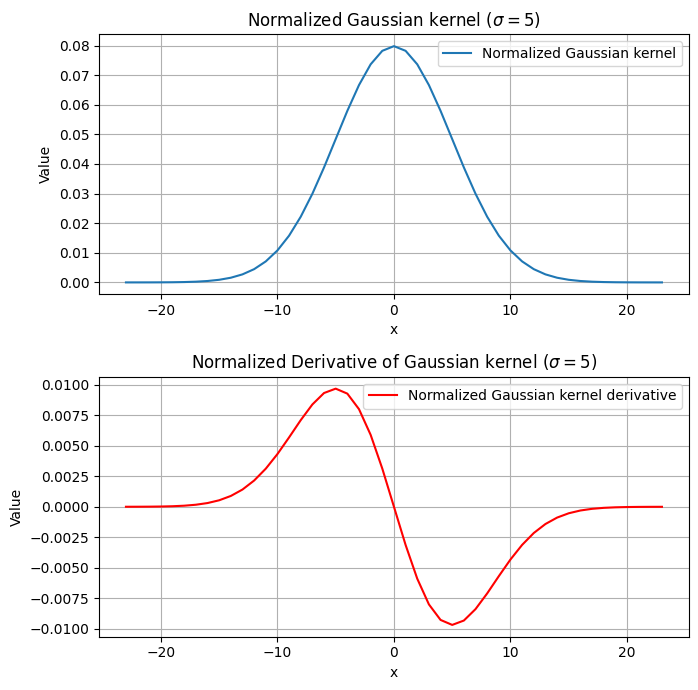

In [20]:
# Plot the kernels
fig, ax = plt.subplots(2, 1, figsize=(7, 7))

# Plot normalized Gaussian kernel
ax[0].plot(x, kernel_1D, label="Normalized Gaussian kernel")
#ax[0].plot(x, gaussian_filter(x, SIGMA, order=0, truncate=2) )
ax[0].set_title(rf"Normalized Gaussian kernel ($\sigma = {SIGMA}$)")
ax[0].set_xlabel("x")
ax[0].set_ylabel("Value")
ax[0].grid()
ax[0].legend()

# Plot normalized derivative of Gaussian kernel
ax[1].plot(x, kernel_1D_grad, label="Normalized Gaussian kernel derivative", color="red")
ax[1].set_title(rf"Normalized Derivative of Gaussian kernel ($\sigma = {SIGMA}$)")
#ax[1].plot(x, gaussian_filter(kernel_1D, SIGMA, order=1, truncate=2.0) )
ax[1].set_xlabel("x")
ax[1].set_ylabel("Value")
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

2. **Experimentally verify the separability of the Gaussian kernel** 

    For this, convolve the test image with a 2D Gaussian kernel. Note that you can get a 2D Gaussian kernel as the outer product of two 1D kernels. Then, convolve the same test image with two orthogonal 1D kernels. You should get the same result, i.e. after subtracting the two images, the image difference should be small. 
    
    **Tip**: use ’bwr’ colormap to visualize the difference image. Look at the sketch in Figure 1.6 to understand what you are testing.

In [21]:
def get_gray_image(path):
    image_original = skimage.io.imread(path)
    return skimage.img_as_float(image_original)

image_original.min()=np.uint16(0), image_original.max()=np.uint16(56436)
image.min()=np.float64(0.0), image.max()=np.float64(0.8611581597619593)


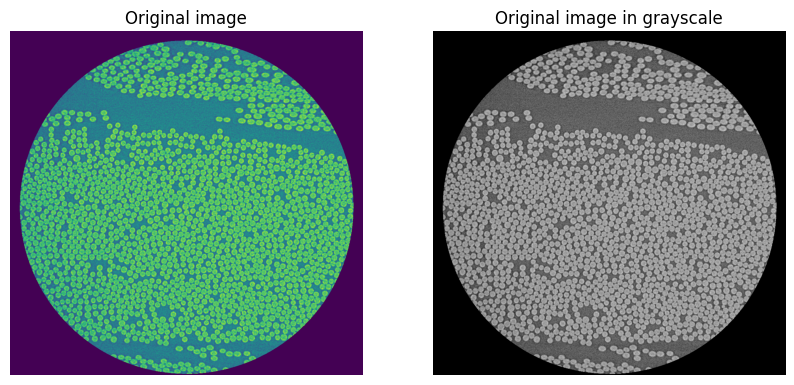

In [22]:
# import image with skimage 
image = get_gray_image(f"{PATH}fibres_xcth.png")
image_original = skimage.io.imread(f"{PATH}fibres_xcth.png")

# Print the max and min values for the images (used to ensure that we have the correct range and type)
print(f'{image_original.min()=}, {image_original.max()=}')
print(f'{image.min()=}, {image.max()=}')

# plot the images
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image_original)
ax[0].set_title("Original image")
ax[0].axis('off')
ax[1].imshow(image, cmap='gray', vmin=0, vmax=1)
ax[1].set_title("Original image in grayscale")
ax[1].axis('off')
plt.show()

Shape of the 2D kernel: (47, 47)


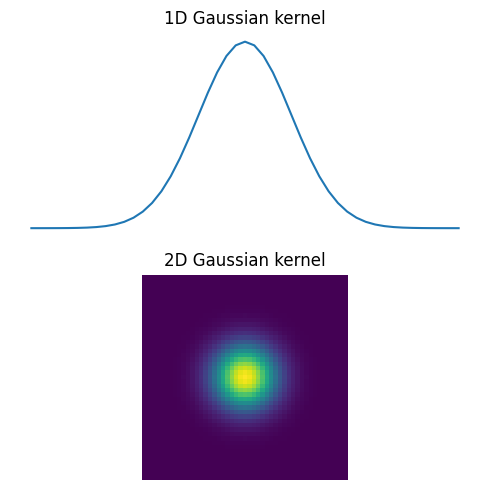

In [23]:
# create 2D kernel by outer product of the 1D kernels
kernel_2d = np.outer(gaussian_1D_kernel(N, SIGMA**2), gaussian_1D_kernel(N, SIGMA**2))
print(f"Shape of the 2D kernel: {kernel_2d.shape}")

# visualize the kernel 
fig, ax = plt.subplots(2, 1, figsize=(5, 5))
ax[0].plot(gaussian_1D_kernel(N, SIGMA**2))
ax[0].set_title("1D Gaussian kernel")
ax[0].axis('off')
ax[1].imshow(kernel_2d, cmap='viridis')
ax[1].set_title("2D Gaussian kernel")
ax[1].axis('off')
plt.tight_layout()
plt.show()

Shape of the original image: (988, 1013)
Shape of the blurred image: (988, 1013)


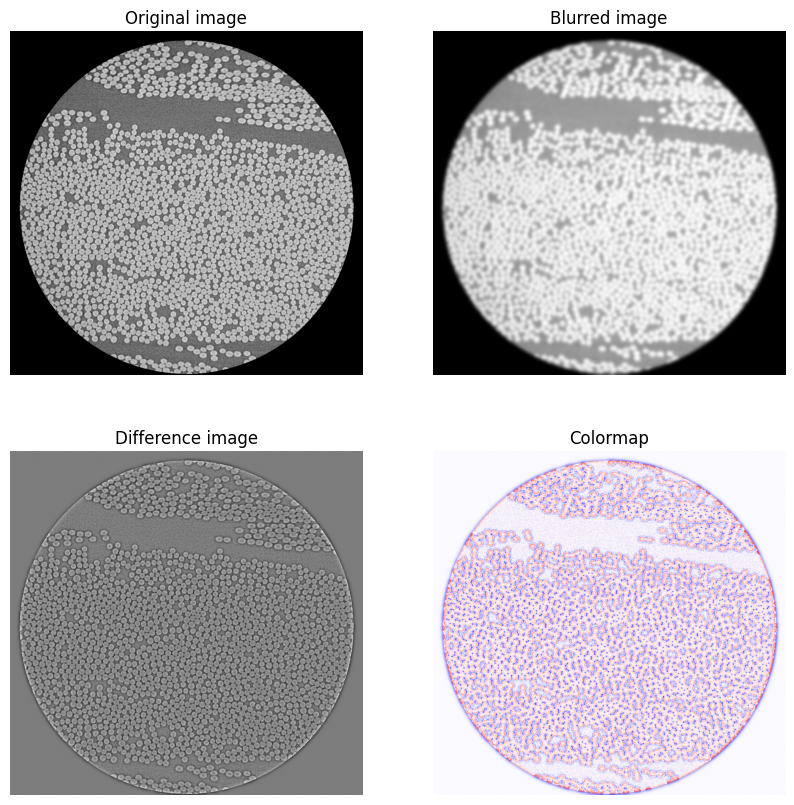

In [24]:
image_blurred = convolve(image, kernel_2d)
print(f"Shape of the original image: {image.shape}")
print(f"Shape of the blurred image: {image_blurred.shape}")

difference_image = image - image_blurred

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(image, cmap='gray')
ax[0][0].set_title("Original image")
ax[0][0].axis('off')
ax[0][1].imshow(image_blurred, cmap='gray')
ax[0][1].set_title("Blurred image")
ax[0][1].axis('off')
ax[1][0].imshow(difference_image, cmap='gray')
ax[1][0].set_title("Difference image")
ax[1][0].axis('off')
ax[1][1].imshow(difference_image, cmap='bwr')
ax[1][1].set_title("Colormap")
ax[1][1].axis('off')
plt.show()


Shape of the column-wise kernel: (47, 1)
Shape of the image after column-wise convolution: (988, 1013)
Shape of the row-wise kernel: (1, 47)
Shape of the image after row-wise convolution: (988, 1013)


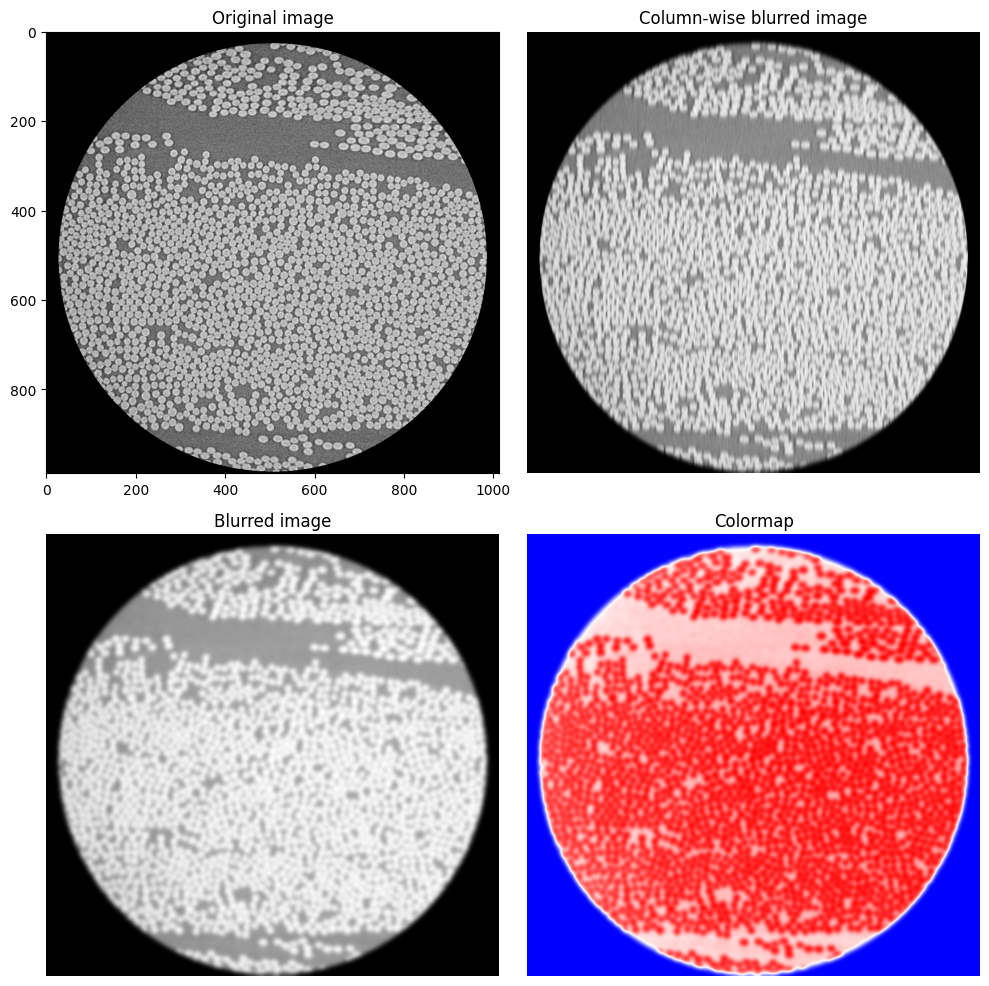

In [25]:

# convolve column wise
column_wise_gaussian_kernel = kernel_1D.reshape(-1, 1)
print(f"Shape of the column-wise kernel: {column_wise_gaussian_kernel.shape}")
image_columns = convolve(image, column_wise_gaussian_kernel)
print(f"Shape of the image after column-wise convolution: {image_columns.shape}")


# then convolve along the rows 
row_wise_gaussian_kernel = kernel_1D.reshape(1, -1)
print(f"Shape of the row-wise kernel: {row_wise_gaussian_kernel.shape}")
image_rows = convolve(image_columns, row_wise_gaussian_kernel)
print(f"Shape of the image after row-wise convolution: {image_rows.shape}")

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(image, cmap='gray')
ax[0][0].set_title("Original image")
ax[0][1].axis('off')
ax[0][1].imshow(image_columns, cmap='gray')
ax[0][1].set_title("Column-wise blurred image")
ax[0][1].axis('off')
ax[1][0].imshow(image_rows, cmap='gray')
ax[1][0].set_title("Blurred image")
ax[1][0].axis('off')
ax[1][1].imshow(image_rows, cmap='bwr')
ax[1][1].set_title("Colormap")
ax[1][1].axis('off')
plt.tight_layout()
plt.show()

**3 Experimentally verify the equation below**

\begin{equation}
    \frac{\partial}{\partial x} (I * g) = \frac{\partial I}{\partial x} * g = I * \frac{\partial g}{\partial x}
\end{equation}

It is enough to test the 1D case. That is, obtain one result by convolving the image with 1D Gaussian, and take the derivative in the same direction. You can compute the derivative by convolving the image with the kernel [0.5, 0, −0.5]. Obtain the second result by convolving the image with the derivative of the Gaussian. Verify that the difference between the two results is small. '

**Hint:** compute the average absolute difference between the two images.

Shape of the column-wise kernel: (47, 1)
Shape of the image after column-wise convolution: (988, 1013)


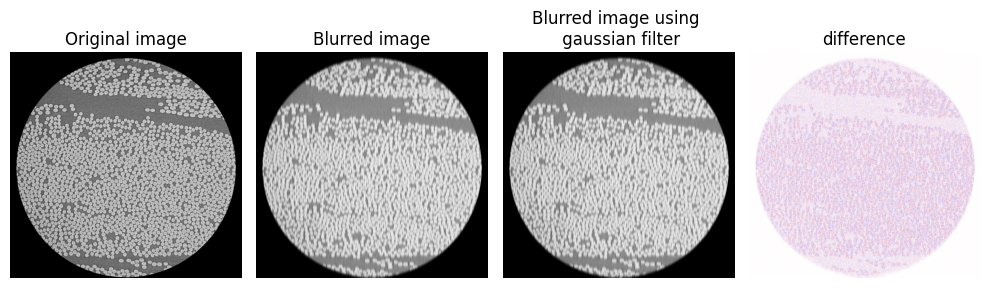

In [26]:
image = get_gray_image(f"{PATH}fibres_xcth.png")

SIGMA = 5
N = 4.5
RADIUS = np.ceil(N * SIGMA)
x = np.arange(-RADIUS, RADIUS + 1)
kernel_1D = gaussian_1D_kernel(N, SIGMA**2)

# define the kernel as a column vector
gaussian_kernel_column = kernel_1D.reshape(-1, 1)
print(f"Shape of the column-wise kernel: {gaussian_kernel_column.shape}")

# convolve the image with the kernel
image_blurred = convolve(image, gaussian_kernel_column)
print(f"Shape of the image after column-wise convolution: {image_blurred.shape}")

image_blurred_filter = gaussian_filter(image, SIGMA, axes=0, truncate=N)

# visualize the image
fig, ax = plt.subplots(1, 4, figsize=(10, 10))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original image")
ax[0].axis('off')
ax[1].imshow(image_blurred, cmap='gray')
ax[1].set_title("Blurred image")
ax[1].axis('off')
ax[2].imshow(image_blurred_filter, cmap='gray')
ax[2].set_title("Blurred image using \n gaussian filter")
ax[2].axis('off')
ax[3].imshow(image_blurred_filter - image_blurred, cmap='bwr')
ax[3].set_title("difference")
ax[3].axis('off')

plt.tight_layout()
plt.show()

assert np.allclose(image_blurred, image_blurred_filter, atol=1e-6), "Gaussian filter output does not match!"

Shape of the derivative kernel: (3, 1)


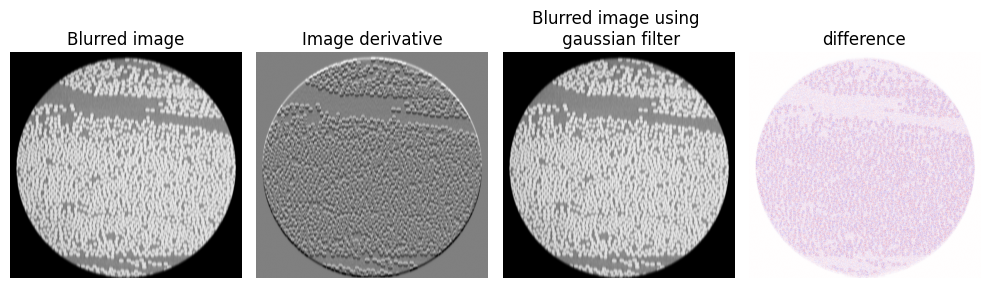

In [27]:
# derivative of the blurred image 
derivative_kernel = np.array([0.5, 0, -0.5]).reshape(-1, 1)
print(f"Shape of the derivative kernel: {derivative_kernel.shape}")

image_derivative = convolve(image_blurred, derivative_kernel)

#image_derivative_filter = gaussian_filter(image_blurred, SIGMA)

# visualize the image derivative (single image)

fig, ax = plt.subplots(1, 4, figsize=(10, 10))
ax[0].imshow(image_blurred, cmap='gray')
ax[0].set_title("Blurred image")
ax[0].axis('off')
ax[1].imshow(image_derivative, cmap='gray')
ax[1].set_title("Image derivative")
ax[1].axis('off')
ax[2].imshow(image_blurred_filter, cmap='gray')
ax[2].set_title("Blurred image using \n gaussian filter")
ax[2].axis('off')
ax[3].imshow(image_blurred_filter - image_blurred, cmap='bwr')
ax[3].set_title("difference")
ax[3].axis('off')


plt.tight_layout()
plt.show()

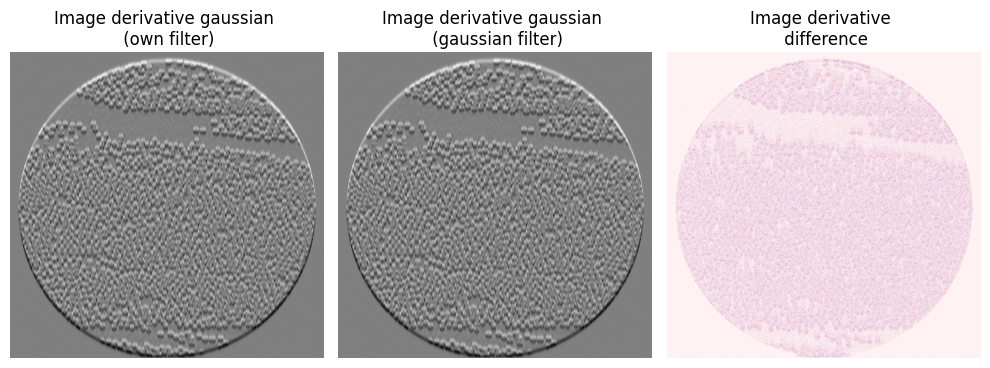

The absolute average difference is 3.4656022627759667e-18


In [28]:
# convolve the image with the derivative kernel
image_derivative_gaussian = convolve(image, kernel_1D_grad.reshape(-1, 1))
image_derivative_filter = gaussian_filter(image, SIGMA, order=1, truncate=N, axes=0)

image_derivative_difference = image_derivative_filter - image_derivative_gaussian
# visualize the image derivative (single image)
fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(image_derivative_gaussian, cmap='gray')
ax[0].set_title("Image derivative gaussian \n (own filter)")
ax[0].axis('off')
ax[1].imshow(image_derivative_filter, cmap='gray')
ax[1].set_title("Image derivative gaussian \n (gaussian filter)")
ax[1].axis('off')
ax[2].imshow(image_derivative_difference, cmap='bwr')
ax[2].set_title("Image derivative \n difference")
ax[2].axis('off')
plt.tight_layout()
plt.show()

print(f'The absolute average difference is {np.mean(np.abs(image_derivative_difference))}')

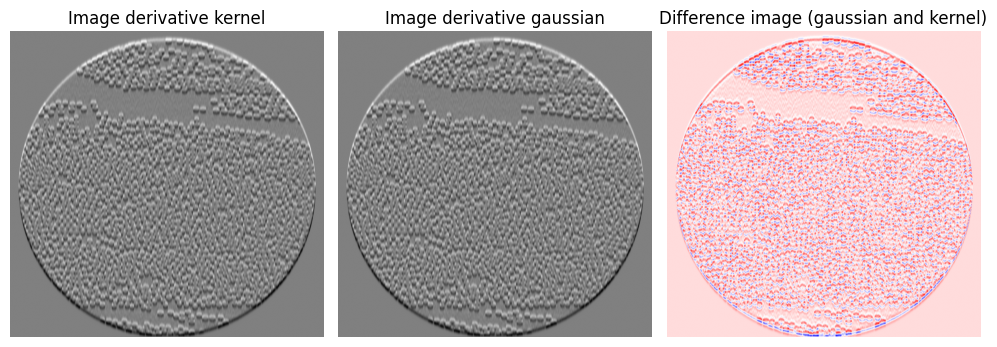

Average absolute difference between the two images: 0.0001


In [29]:
# calculate the difference between the two iamges 
difference_image = image_derivative_gaussian - image_derivative

# visualize the difference image
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(image_derivative, cmap='gray')
ax[0].set_title("Image derivative kernel")
ax[0].axis('off')
ax[1].imshow(image_derivative_gaussian, cmap='gray')
ax[1].set_title("Image derivative gaussian")
ax[1].axis('off')
ax[2].imshow(difference_image, cmap='bwr')
ax[2].set_title("Difference image (gaussian and kernel)")
ax[2].axis('off')
plt.tight_layout()
plt.show()


average_absolute_difference = np.mean(np.abs(image_derivative_gaussian - image_derivative))
print(f"Average absolute difference between the two images: {average_absolute_difference:.4f}")

4  **Verify multiple of convolutions**

Verify that a convolution with a Gaussian of $t = 20$ is equal to ten convolutions with a Gaussian of $t = 2$. Remember that $\sigma = \sqrt{t}$. You can again compare the two images by showing the difference.


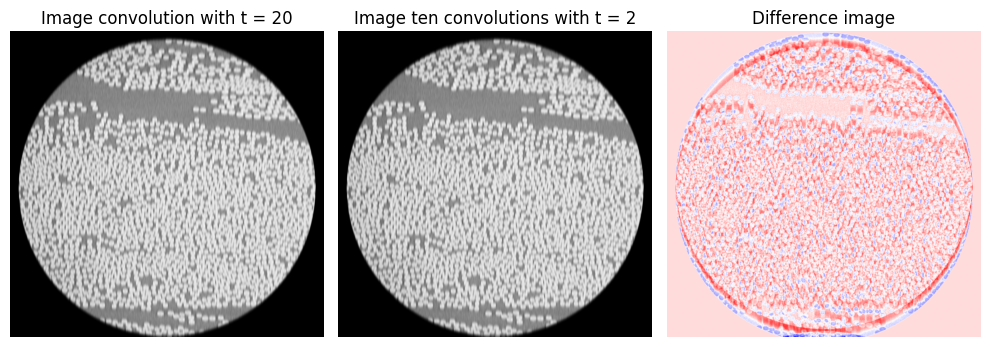

Average absolute difference between the two images: 0.0000


In [30]:
kernel_t_20 = gaussian_1D_kernel(N, 20)
kernel_t_2 = gaussian_1D_kernel(N, 2)

image_t_20 = convolve(image, kernel_t_20.reshape(-1, 1))
image_t_2 = convolve(image, kernel_t_2.reshape(-1, 1))
for i in range(9):
    image_t_2 = convolve(image_t_2, kernel_t_2.reshape(-1, 1))

#Take the difference between the two images
difference_image = image_t_20 - image_t_2

# visualize the difference image
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(image_t_2, cmap='gray')
ax[0].set_title("Image convolution with t = 20")
ax[0].axis('off')
ax[1].imshow(image_t_20, cmap='gray')
ax[1].set_title("Image ten convolutions with t = 2")
ax[1].axis('off')
ax[2].imshow(difference_image, cmap='bwr')
ax[2].set_title("Difference image")
ax[2].axis('off')
plt.tight_layout()
plt.show()

average_absolute_difference = np.mean(np.abs(image_t_20 - image_t_2))
print(f"Average absolute difference between the two images: {average_absolute_difference:.4f}")

5 **Verify that a convolution with a Gaussian derivative of $t = 20$ is equal to convolving with a Gaussian of $t = 10$ and a Gaussian derivative of $t = 10$**

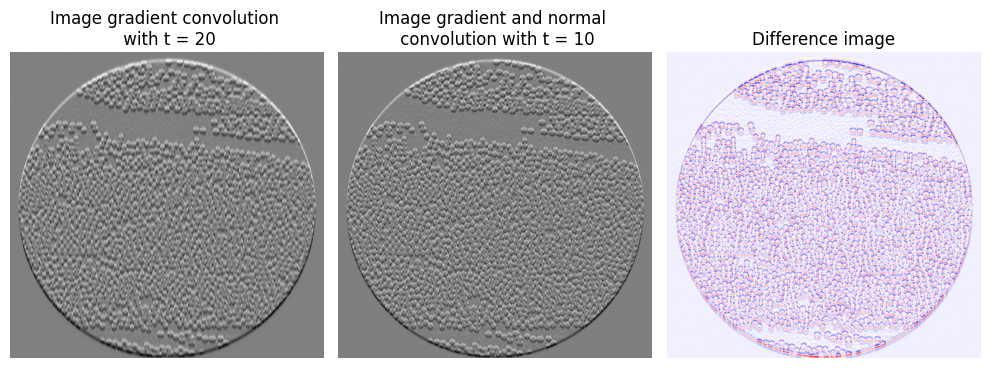

Average absolute difference between the two images: 0.0042


In [31]:
kernel_grad_t_20 = gaussian_1D_grad(N, 20)

kernel_t_10 = gaussian_1D_kernel(N, 10)
kernel_grad_t_10 = gaussian_1D_grad(N, 10)

image_grad_t_20 = convolve(image, kernel_grad_t_20.reshape(-1, 1))
image_t_10 = convolve(image, kernel_t_10.reshape(-1, 1))
image_grad_t_10 = convolve(image, kernel_grad_t_10.reshape(-1, 1))

difference_image = image_grad_t_20 - image_grad_t_10

# visualize the difference image
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(image_grad_t_20, cmap='gray')
ax[0].set_title("Image gradient convolution \n with t = 20")
ax[0].axis('off')
ax[1].imshow(image_grad_t_10, cmap='gray')
ax[1].set_title("Image gradient and normal \n convolution with t = 10")
ax[1].axis('off')
ax[2].imshow(difference_image, cmap='bwr')
ax[2].set_title("Difference image")
ax[2].axis('off')
plt.tight_layout()
plt.show()

average_absolute_difference = np.mean(np.abs(difference_image))
print(f"Average absolute difference between the two images: {average_absolute_difference:.4f}")

## Exercise Overview
Segmentation is one of the basic image analysis tasks. The length of the segmentation boundary may be used as a measure of segmentationquality, and we will calculate it in this exercise

## Data
You may use any image with discrete pixel values. We have provided the segmentation images ```fuel_cell_1.tif```, ```fuel_cell_2.tif```, and ```fuel_cell_3.tif```.

## <span style="color:green;">1.1.2 Tasks </span>




1. **Compute the length of the segmentation boundary for all images**

2. **Try avoiding loops**

    Instead use vectorization provided by numpy for an efficient and compact implementation. See the figure below for a sketch of the vectorization approach.

<p align="center">
  <img src="figures/table.png" width="800">
</p>
    

3. **Collect your code in a function**
  
  The function should take segmentation as an input and returns the length of the segmentation boundary as an output.

In [43]:
def segmentation_length(image):
    """
    Calculate the segmentation length of a binary image.

    The segmentation length is defined as the total number of transitions 
    between 0 and 1 (or 1 and 0) along both the vertical and horizontal 
    directions in the image.

    Parameters:
    image (numpy.ndarray): A 2D binary numpy array representing the image.

    Returns:
    int: The total number of transitions in the image.
    """
    count_vertically = np.sum(image[1:, :] != image[:-1,:])
    count_horizontally = np.sum(image[:, 1:] != image[:,:-1])
    return count_vertically + count_horizontally

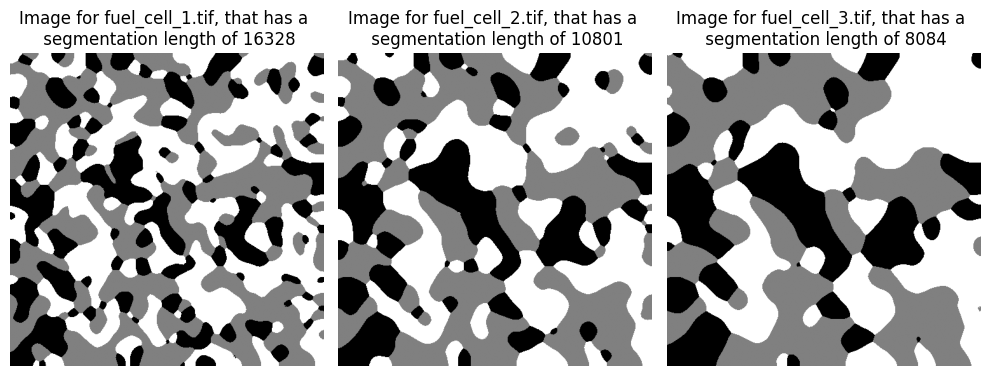

In [44]:
# names of the images to plot and calculate segmentation length off
name_list = ['fuel_cell_1.tif', 'fuel_cell_2.tif', 'fuel_cell_3.tif']

#Initialize the image
fig, ax = plt.subplots(1, 3, figsize=(10, 10))

for i, name in enumerate(name_list):
    image_original = skimage.io.imread(f"{PATH}/fuel_cells/{name}")
    image = skimage.img_as_float(image_original)
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(f"Image for {name}, that has a \n segmentation length of {segmentation_length(image)}")
    ax[i].axis('off')

plt.tight_layout()
plt.show()

From the plot above we can see, that we get a larger segmentation length for the smaller segmentation areas which makes sense 

## Exercise 

Apply curve smoothing

## Data

In this exercise you should use the curves given as text files containing point coordinates ```hand_noisy.txt``` (shown in the figure below), and ```hand_noisy.txt```. We have also provided curves without the noise. The curves may be loaded using ```numpy.loadtxt```.

**Hints**

To create the matrices, you can use the function ```circulant``` from ```scipy.linalg```. To invert a matrix, you can use ```numpy.linalg.inv```.

<p align="center">
  <img src="Figures/dino_figure.png" width="300">
</p>
    

## 1.1.3 Tasks

1. **Implement curve smoothing *"Explicit (forward) smooting"***

    Visually confirm that one step with $\lambda = 0.5$ displaces every curve point exactly to the average of its neighbors. Try iteratively smoothing one of the provided noisy contours. Try visualizing every iteration, see the provided notebook for inspiration. What happens when you increase $\lambda$? How many iterations do you need to achieve a visible result for small $\lambda$?. For this exercise use the following equation

    \begin{equation}
        \bm{X}_\text{new} = (\bm{I} + \lambda \bm{L})\bm{X} 
    \end{equation}

2. **Implement curve smoothing using implicit smoothing**

    Implement and and test it for various values of $\lambda$. Do you need an iterative approach of this smoothing? For this exercise use the following equation

    \begin{equation}
        \bm{X}_\text{new} = (\bm{I} - \lambda \bm{L})^{-1} \bm{X} 
    \end{equation}

3. **Implement implicit curve smoothing but with the extended kernel**

    This means that your implementation instead of $\lambda \bm{L}$ uses a matrix $\alpha \bm{A} + \beta \bm{B}$. Test smoothing with various values of $\alpha$ and $\beta$. What do you achieve when choosing a large $\beta$ and small $\alpha$? For this exercise you should use the following equation

    \begin{equation}
        \bm{X}_\text{new} = (\bm{I} - \alpha \bm{A} - \beta \bm{B})^{-1} \bm{X} 
    \end{equation}
    
4. **Implement a function**
    
    Implement a function which given $N$, $\alpha$ and $\beta$ returns $(\bm{I} − \alpha \bm{A} − \beta \bm{B})^{−1}$ to be used for smoothing.

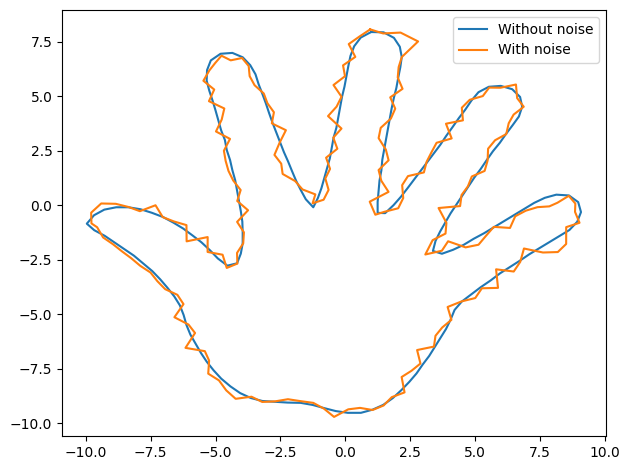

In [45]:
# Get the data
hand = np.loadtxt(f"{PATH}curves/hand.txt")
hand_closed = np.vstack([hand, [hand[0,0], hand[0,1]]]) #add the first point to the end to connect the curve

hand_noisy = np.loadtxt(f"{PATH}curves/hand_noisy.txt")
hand_noisy_closed = np.vstack([hand_noisy, hand_noisy[0,:]])

# Plot the data
plt.figure
plt.plot(hand_closed[:,0], hand_closed[:,1], label='Without noise')
plt.plot(hand_noisy_closed[:,0], hand_noisy_closed[:,1], label='With noise')
plt.legend()
plt.tight_layout()
plt.show()

 Explicit smoothing works only for small λ (try for example a value 1.5 in the cell above).  To achieve more aggressive smoothing, we need to smooth iteratively.  This requires setting two parameters: λ and the number of iterations.

1. **Implement curve smoothing**

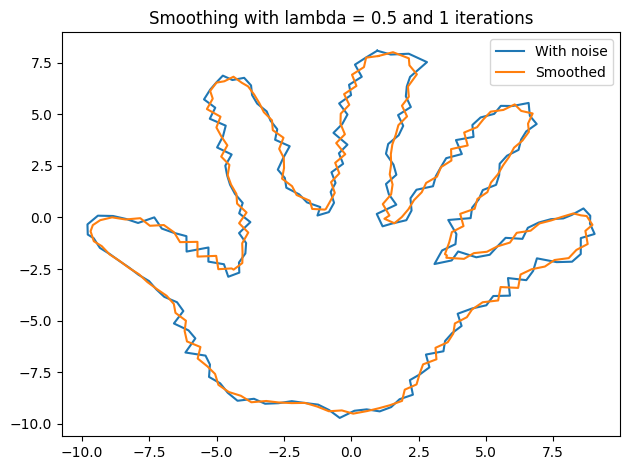

Is the function working? True


In [46]:
LAMBDA = 0.5
ITERATION = 1
hand_smooth = smoothing_explicit(hand_noisy, LAMBDA, ITERATION)
hand_smooth_closed = np.vstack([hand_smooth, hand_smooth[0,:]])

plt.figure
plt.plot(hand_noisy_closed[:,0], hand_noisy_closed[:,1], label='With noise')
plt.plot(hand_smooth_closed[:,0], hand_smooth_closed[:,1], label='Smoothed')
plt.title(f'Smoothing with lambda = {LAMBDA} and {ITERATION} iterations')
plt.legend()
plt.tight_layout()
plt.show()

#check that the function give the same result as the code above
hand_smooth_func = smoothing_explicit(hand_noisy, LAMBDA)
print(f'Is the function working? {np.allclose(hand_smooth_func, hand_smooth)}')


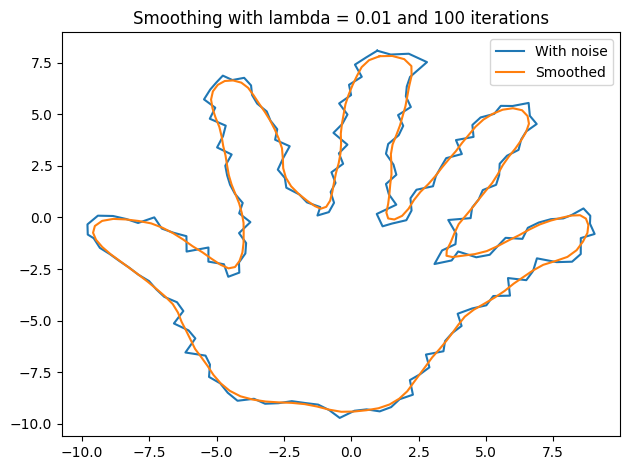

In [47]:
LAMBDA = 0.01
ITERATION = 100
hand_smooth = smoothing_explicit(hand_noisy, LAMBDA, ITERATION)
hand_smooth_closed = np.vstack([hand_smooth, hand_smooth[0,:]])

plt.figure
plt.plot(hand_noisy_closed[:,0], hand_noisy_closed[:,1], label='With noise')
plt.plot(hand_smooth_closed[:,0], hand_smooth_closed[:,1], label='Smoothed')
plt.title(f'Smoothing with lambda = {LAMBDA} and {ITERATION} iterations')
plt.legend()
plt.tight_layout()
plt.show()

From the image above, we can see that a point for our smoothed hand is equal the average of the noisy hand, which is should be due to the kernel $[1, -2, 1]$

In [48]:
len_data = len(hand_noisy)
I = np.eye(len_data)
vec = np.zeros(len_data)
vec[-1], vec[0], vec[1] = 1, -2, 1 

# create matrix L and print for sanity check
L = circulant(vec)

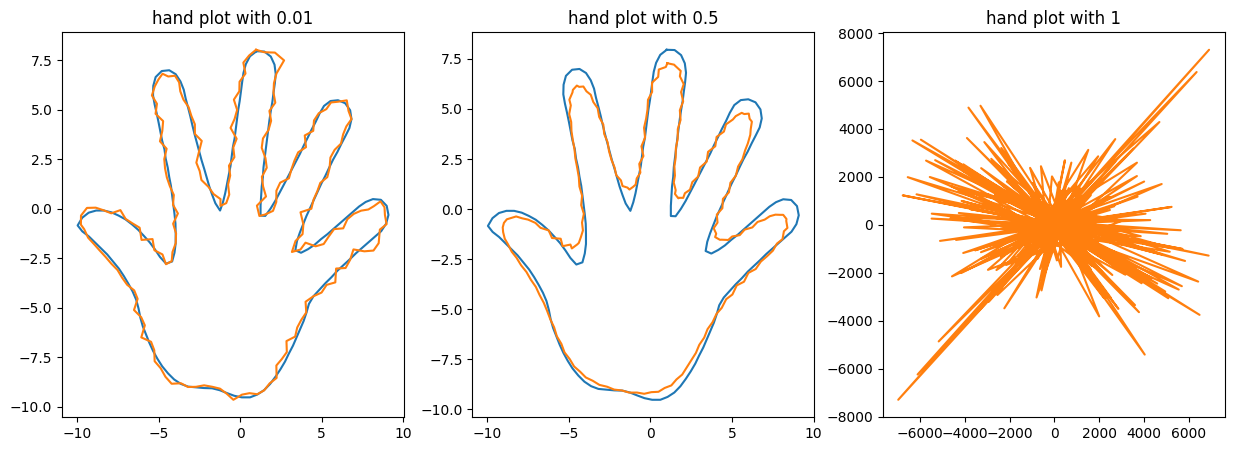

Is the function working? True


In [49]:
LAMBDA_LOW = 0.01
LAMBDA_MEDIUM = 0.5
LAMBDA_HIGH = 1
ITERATIONS = 10

hand_smooth_low     = (I + LAMBDA_LOW*L) @ hand_noisy
hand_smooth_medium  = (I + LAMBDA_MEDIUM*L) @ hand_noisy
hand_smooth_high    = (I + LAMBDA_HIGH*L) @ hand_noisy

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for _ in range(ITERATIONS - 1):

    hand_smooth_low =     (I + LAMBDA_LOW*L) @ hand_smooth_low
    hand_smooth_medium  = (I + LAMBDA_MEDIUM*L) @ hand_smooth_medium
    hand_smooth_high   =  (I + LAMBDA_HIGH*L) @ hand_smooth_high

    hand_smooth_low_closed = np.vstack([hand_smooth_low, hand_smooth_low[0,:]])
    hand_smooth_medium_closed = np.vstack([hand_smooth_medium, hand_smooth_medium[0,:]])
    hand_smooth_high_closed = np.vstack([hand_smooth_high, hand_smooth_high[0,:]])

    ax[0].clear(), ax[1].clear(), ax[2].clear()  # Prevent matplotlib accumulating all it has drawn.
    ax[0].set_title(f'hand plot with {LAMBDA_LOW}'), ax[1].set_title(f'hand plot with {LAMBDA_MEDIUM}'), ax[2].set_title(f'hand plot with {LAMBDA_HIGH}')
    ax[0].plot(hand_closed[:,0], hand_closed[:,1], label='Without noise')
    ax[0].plot(hand_smooth_low_closed[:,0], hand_smooth_low_closed[:,1], label=f'Smoothed with low {LAMBDA_LOW}')
    ax[1].plot(hand_closed[:,0], hand_closed[:,1], label='Without noise')
    ax[1].plot(hand_smooth_medium_closed[:,0], hand_smooth_medium_closed[:,1], label=f'Smoothed with medium {LAMBDA_MEDIUM}')
    ax[2].plot(hand_closed[:,0], hand_closed[:,1], label='Without noise')
    ax[2].plot(hand_smooth_high_closed[:,0], hand_smooth_high_closed[:,1], label=f'Smoothed with low {LAMBDA_HIGH}')        
    display(fig)
    clear_output(wait=True)  # Removes the figure display
plt.show()

hand_smooth_high_func = smoothing_explicit(hand_noisy, LAMBDA_HIGH, 10)

print(f'Is the function working? {np.allclose(hand_smooth_high_func, hand_smooth_high)}')


In the image to the left, the value is so low, that nothing happens and I will therefore need more iterations. The one in the middle will smooth and the last image will explode due to the high value.

2. **Implement curve smoothing using implicit smoothing**

Is the function working? True


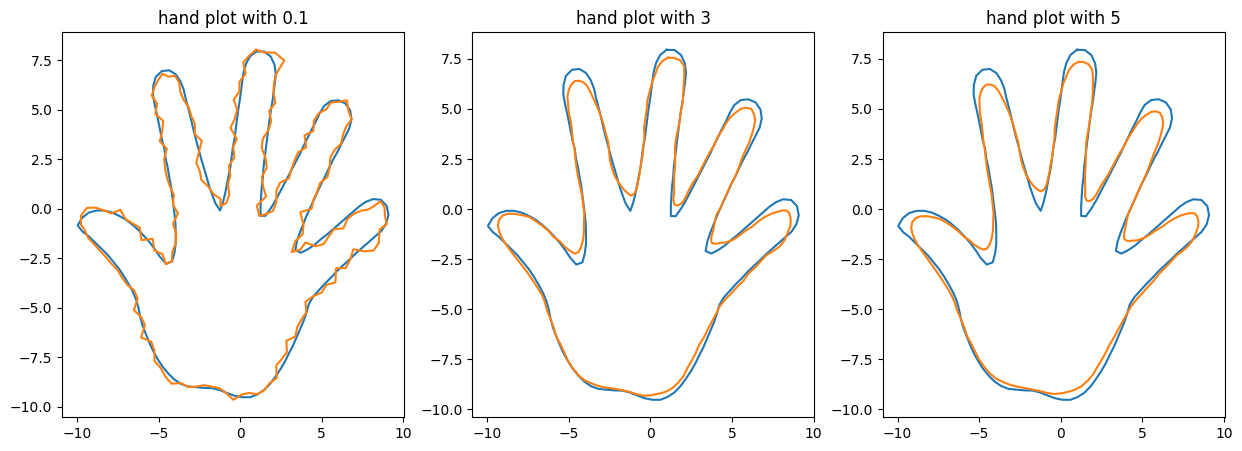

In [50]:
# I use the code from above and implement the inverse
LAMBDA_LOW = 0.1
LAMBDA_MEDIUM = 3
LAMBDA_HIGH = 5

hand_smooth_low     = smoothing_implicit(hand_noisy, LAMBDA_LOW)
hand_smooth_medium  = smoothing_implicit(hand_noisy, LAMBDA_MEDIUM)
hand_smooth_high    = smoothing_implicit(hand_noisy, LAMBDA_HIGH)

hand_smooth_low_closed = np.vstack([hand_smooth_low, hand_smooth_low[0,:]])
hand_smooth_medium_closed = np.vstack([hand_smooth_medium, hand_smooth_medium[0,:]])
hand_smooth_high_closed = np.vstack([hand_smooth_high, hand_smooth_high[0,:]])

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].set_title(f'hand plot with {LAMBDA_LOW}'), ax[1].set_title(f'hand plot with {LAMBDA_MEDIUM}'), ax[2].set_title(f'hand plot with {LAMBDA_HIGH}')
ax[0].plot(hand_closed[:,0], hand_closed[:,1], label='Without noise')
ax[0].plot(hand_smooth_low_closed[:,0], hand_smooth_low_closed[:,1], label=f'Smoothed with low {LAMBDA_LOW}')
ax[1].plot(hand_closed[:,0], hand_closed[:,1], label='Without noise')
ax[1].plot(hand_smooth_medium_closed[:,0], hand_smooth_medium_closed[:,1], label=f'Smoothed with medium {LAMBDA_MEDIUM}')
ax[2].plot(hand_closed[:,0], hand_closed[:,1], label='Without noise')
ax[2].plot(hand_smooth_high_closed[:,0], hand_smooth_high_closed[:,1], label=f'Smoothed with low {LAMBDA_HIGH}')  

#check if the function is working
hand_smooth_high_func = smoothing_implicit(hand_noisy, LAMBDA_HIGH)
print(f'Is the function working? {np.allclose(hand_smooth_high_func, hand_smooth_high)}')

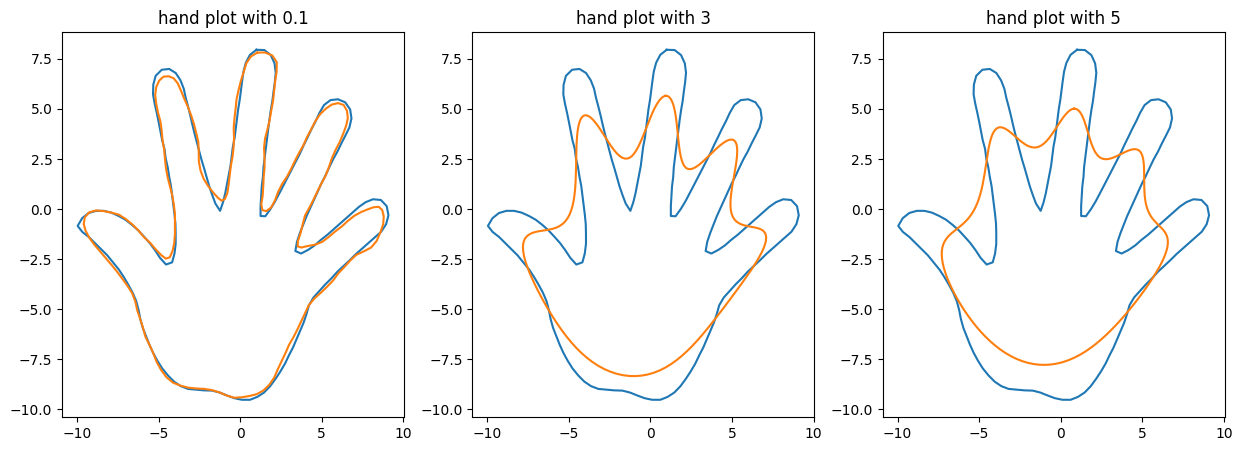

is the function working? True


In [51]:
LAMBDA_LOW = 0.1
LAMBDA_MEDIUM = 3
LAMBDA_HIGH = 5

hand_smooth_low     = np.linalg.inv(I - LAMBDA_LOW*L) @ hand_noisy
hand_smooth_medium  = np.linalg.inv(I - LAMBDA_MEDIUM*L) @ hand_noisy
hand_smooth_high    = np.linalg.inv(I - LAMBDA_HIGH*L) @ hand_noisy

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(9):

    hand_smooth_low     = np.linalg.inv(I - LAMBDA_LOW*L) @ hand_smooth_low
    hand_smooth_medium  = np.linalg.inv(I - LAMBDA_MEDIUM*L) @ hand_smooth_medium
    hand_smooth_high    = np.linalg.inv(I - LAMBDA_HIGH*L) @ hand_smooth_high

    hand_smooth_low_closed = np.vstack([hand_smooth_low, hand_smooth_low[0,:]])
    hand_smooth_medium_closed = np.vstack([hand_smooth_medium, hand_smooth_medium[0,:]])
    hand_smooth_high_closed = np.vstack([hand_smooth_high, hand_smooth_high[0,:]])

    ax[0].clear(), ax[1].clear(), ax[2].clear()  # Prevent matplotlib accumulating all it has drawn.
    ax[0].set_title(f'hand plot with {LAMBDA_LOW}'), ax[1].set_title(f'hand plot with {LAMBDA_MEDIUM}'), ax[2].set_title(f'hand plot with {LAMBDA_HIGH}')
    ax[0].plot(hand_closed[:,0], hand_closed[:,1], label='Without noise')
    ax[0].plot(hand_smooth_low_closed[:,0], hand_smooth_low_closed[:,1], label=f'Smoothed with low {LAMBDA_LOW}')
    ax[1].plot(hand_closed[:,0], hand_closed[:,1], label='Without noise')
    ax[1].plot(hand_smooth_medium_closed[:,0], hand_smooth_medium_closed[:,1], label=f'Smoothed with medium {LAMBDA_MEDIUM}')
    ax[2].plot(hand_closed[:,0], hand_closed[:,1], label='Without noise')
    ax[2].plot(hand_smooth_high_closed[:,0], hand_smooth_high_closed[:,1], label=f'Smoothed with low {LAMBDA_HIGH}')        
    display(fig)
    clear_output(wait=True)  # Removes the figure display

plt.show()

# check that the function works
hand_smooth_high_func = smoothing_implicit(hand_noisy, LAMBDA_HIGH, 10)
print(f'is the function working? {np.allclose(hand_smooth_high, hand_smooth_high_func)}')

I will say that the smoothing gets better when I use the iterative approach, but a different $\lambda$ is needed

3. **Implement implicit curve smoothing but with the extended kernel**

In [52]:
# Make a vector to be used in circulate
alpha_vec = np.zeros(len(hand_noisy))
alpha_vec[-1], alpha_vec[0], alpha_vec[1] = 1, -2, 1 

beta_vec = np.zeros(len(hand_noisy))
beta_vec[-2], beta_vec[-1], beta_vec[0], beta_vec[1], beta_vec[2] = -1, 4, -6, 4, -1

# create matrix L and print for sanity checkA
A = circulant(alpha_vec)
B = circulant(beta_vec)
print('A matrix: \n', A)
print('B matrix: \n', B)

A matrix: 
 [[-2.  1.  0. ...  0.  0.  1.]
 [ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]
 [ 1.  0.  0. ...  0.  1. -2.]]
B matrix: 
 [[-6.  4. -1. ...  0. -1.  4.]
 [ 4. -6.  4. ...  0.  0. -1.]
 [-1.  4. -6. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -6.  4. -1.]
 [-1.  0.  0. ...  4. -6.  4.]
 [ 4. -1.  0. ... -1.  4. -6.]]


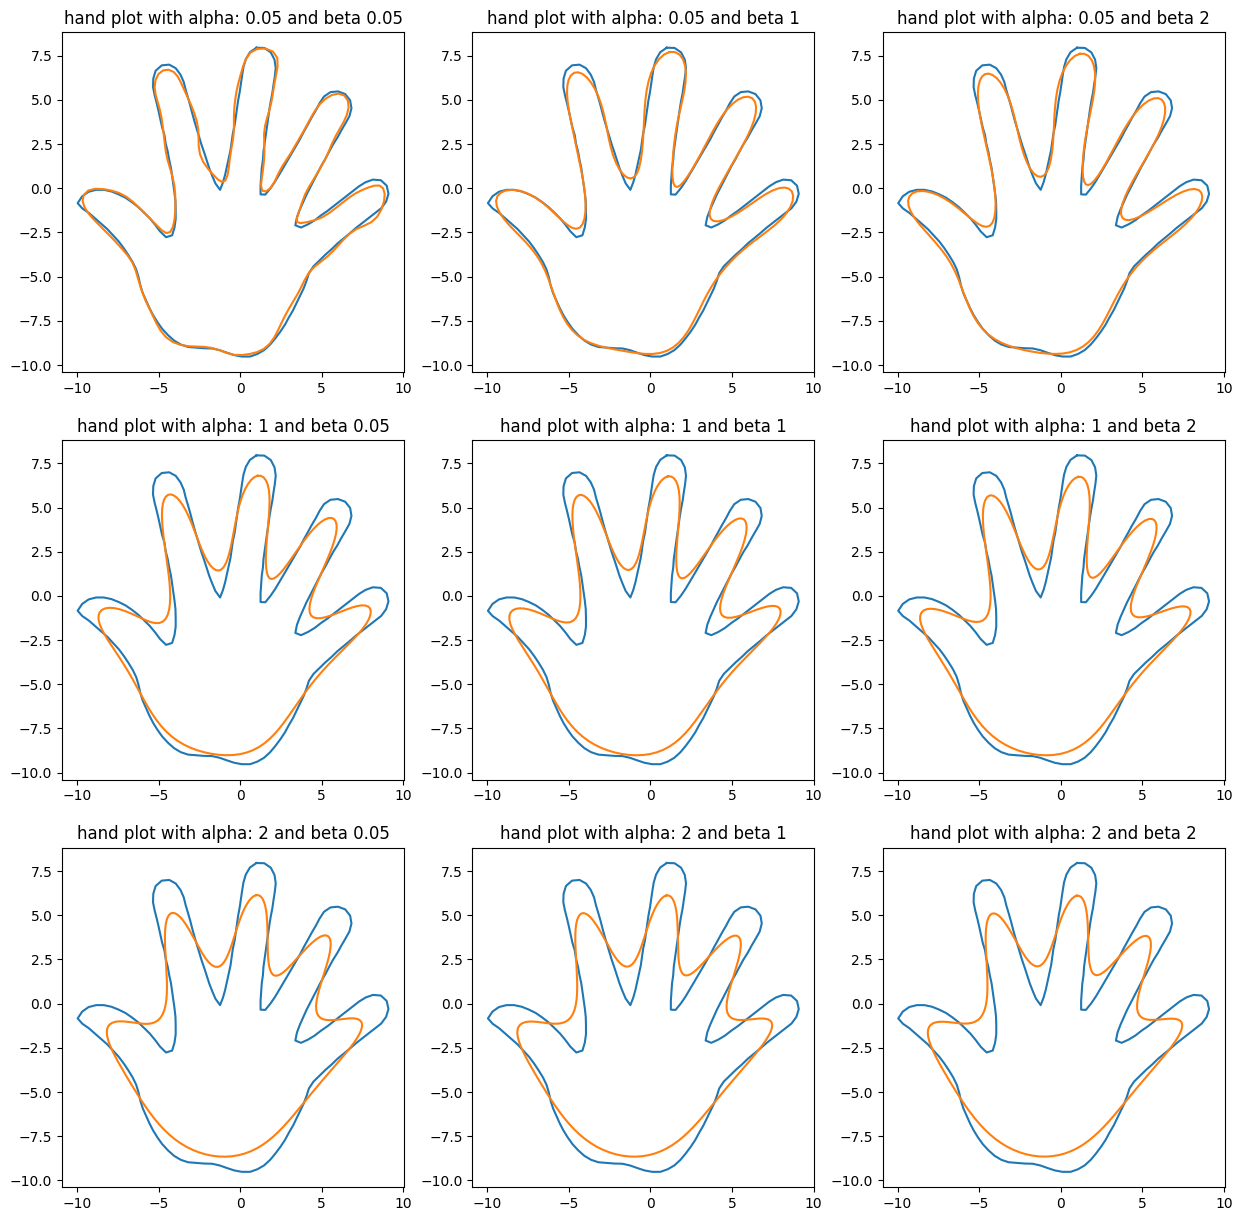

is the function working? True


In [54]:
ALPHA_VALUES = [0.05, 1, 2]
BETA_VALUES = [0.05, 1, 2]

hand_smooth = {}

for alpha in ALPHA_VALUES:
    for beta in BETA_VALUES:
        key = f"alpha_{alpha}_beta_{beta}"
        print
        hand_smooth[key] = np.linalg.inv(I - alpha*A - beta*B) @ hand_noisy

fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i in range(9):
    for alpha_idx, alpha in enumerate(ALPHA_VALUES):
        for beta_idx, beta in enumerate(BETA_VALUES):
            key = f"alpha_{alpha}_beta_{beta}"
            hand_smooth[key] = np.linalg.inv(I - alpha*A - beta*B) @ hand_smooth[key]
            hand_smooth_closed = np.vstack([hand_smooth[key], hand_smooth[key][0,:]])
            ax[alpha_idx, beta_idx].clear()
            ax[alpha_idx, beta_idx].set_title(f'hand plot with alpha: {alpha} and beta {beta}')
            ax[alpha_idx, beta_idx].plot(hand_closed[:,0], hand_closed[:,1], label='Without noise')
            ax[alpha_idx, beta_idx].plot(hand_smooth_closed[:,0], hand_smooth_closed[:,1], label='With smoothing')

    display(fig)
    clear_output(wait=True)  # Removes the figure display
plt.show()

hand_smooth_func = smoothing_alpha_beta(hand_noisy, ALPHA_VALUES[0], BETA_VALUES[0], 10)
print(f'is the function working? {np.allclose(hand_smooth[f"alpha_{ALPHA_VALUES[0]}_beta_{BETA_VALUES[0]}"], hand_smooth_func)}')



For a higher $\beta$ the curves get more smooth (the difference at the neck in plot (1,1) and (1,2)). For a higher $\alpha$ i looks like it will try to center it more

A higher $\alpha$ will prioritize reducing the total curve length, making it smoother but possibly shrinking it

A higher $\beta$ will preserve the overall shape while making it smoother


4 **Implement a function**


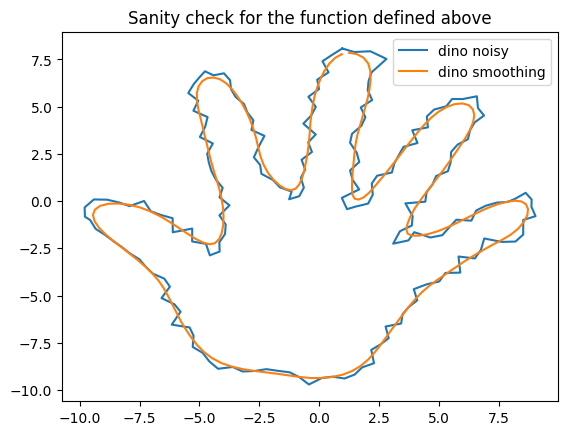

In [ ]:
def smoothing_matrix(alpha, beta, N):
    """
    Generates a smoothing matrix using circulant matrices based on the given parameters.

    Parameters:
        alpha (float): The weight for the first circulant matrix.
        beta (float): The weight for the second circulant matrix.
        N (int): The size of the matrix.
    Returns:
        numpy.ndarray: The resulting smoothing matrix of size NxN.
        
    The function constructs two circulant matrices A and B using the provided alpha and beta values.
    It then computes the smoothing matrix as the inverse of (I - alpha*A - beta*B), where I is the identity matrix.
    """


    # Make a vector to be used in circulate
    alpha_vec = np.zeros(N)
    alpha_vec[-1], alpha_vec[0], alpha_vec[1] = 1, -2, 1 

    beta_vec = np.zeros(N)
    beta_vec[-2], beta_vec[-1], beta_vec[0], beta_vec[1], beta_vec[2] = -1, 4, -6, 4, -1

    A = circulant(alpha_vec)
    B = circulant(beta_vec)

    I = np.eye(N)
    return np.linalg.inv((I - alpha*A - beta*B))


hand_smooth_alpha_beta  = smoothing_matrix(alpha=1, beta=10, N=len(hand_noisy)) @ hand_noisy
hand_smooth_alpha_beta_closed = np.vstack([hand_smooth_alpha_beta, hand_smooth_alpha_beta[0,:]])
plt.title('Sanity check for the function defined above')
plt.plot(hand_noisy_closed[:,0], hand_noisy_closed[:,1], label='hand noisy')
plt.plot(hand_smooth_alpha_beta_closed[:,0], hand_smooth_alpha_beta_closed[:,1], label='hand smoothing')
plt.legend()


# Quiz

<span style="color:red;">**this code should be checked through**</span>

Which number appears in the center of the image when you convolve the ``imagenoisy_number_2023.png`` with an appropriately large Gaussian kernel? (Inconnection to 1.1.1)

In [ ]:
def convolve_2d(image, kernel):
    """
    Applies a 2D convolution to an image using the specified kernel.

    Parameters:
        kernel (numpy.ndarray): The convolution kernel to be applied with shape (x,).
        image (numpy.ndarray): The input image to be convolved.

    Returns:
        numpy.ndarray: The convolved image.

    Note:
    This function performs the convolution in two steps:
    1. Convolves the image with the kernel reshaped to a column vector.
    2. Convolves the result with the kernel reshaped to a row vector.
    """
    image_blurred = convolve(image, kernel.reshape(-1,1))
    return convolve(image_blurred, kernel.reshape(1,-1))

151


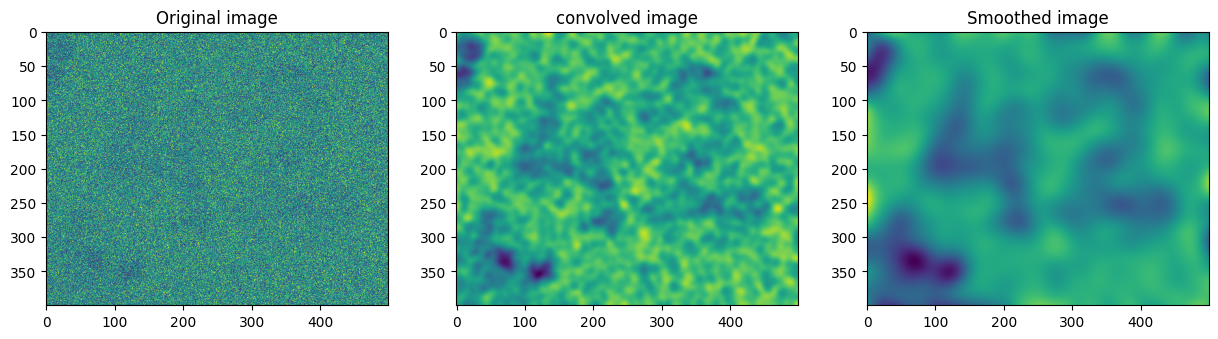

In [ ]:
# load the image
image = get_gray_image(PATH + 'noisy_number_2023.png')

# Make the vector for the kernel
SIGMA = 15
N = 5

# Make the kernel
kernel = gaussian_1D_kernel(N, SIGMA**2)
print(len(kernel))
image_blurred = convolve_2d(image, kernel)
image_smoothed = gaussian_filter(image, SIGMA, mode='nearest')


# Blur the image
image_blurred = convolve(image, kernel_2d)

fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].set_title('Original image')
ax[0].imshow(image)
ax[1].set_title('convolved image')
ax[1].imshow(image_blurred)
ax[2].set_title('Smoothed image')
ax[2].imshow(image_smoothed)


From the above the number is 42

2. What is the boundary length computed from the image ``fuel_cell_2.tif``? (In connection to 1.1.2)

10801


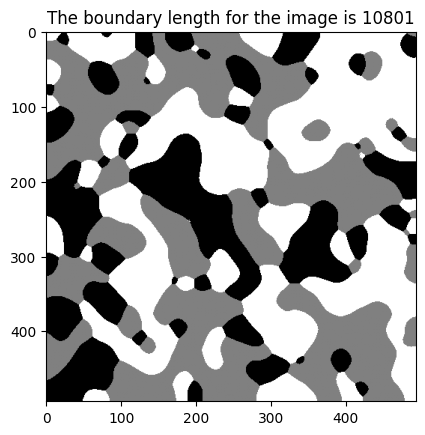

In [ ]:
image = get_gray_image(PATH + 'fuel_cells/fuel_cell_2.tif')

print(segmentation_length(image))
plt.figure()
plt.title(f'The boundary length for the image is {segmentation_length(image)}')
plt.imshow(image, cmap='gray')


The boundary length is 10801

3 What is the length of the curve computed by smoothing ``hand_noisy.txt`` curve using Equation 1.10 and the parameter $\lambda = 0.19$? (In connection to 1.1.3)

In [ ]:
def curve_length(data):
    """
    Calculate the length of a curve given its data points.

    Parameters:
        data (numpy.ndarray): A 2D array of shape (n, 2) representing the coordinates of the curve points.

    Returns:
        float: The total length of the curve.
    """
    d = (np.sqrt(((data - np.roll(data, shift=1, axis=0))**2).sum(axis=1))).sum()
    return d

# Method from AI
# distances = np.linalg.norm(hand_smooth[1:] - dino_smooth[:-1], axis=1)
# total_distance = np.sum(distances)

# My method 
# diff = hand_smooth[:-1,:] -  hand_smooth[1:,:] #Take the difference between the points 
# point = np.sum(diff**2,axis=-1) # calculate a^2 + b^2 for each row
# point = np.sqrt(point) # take the sqrt for each row
# distances = np.sum(point) # summarize all the distances


Text(0.5, 1.0, 'The length for the smoothed dino is 80.002')

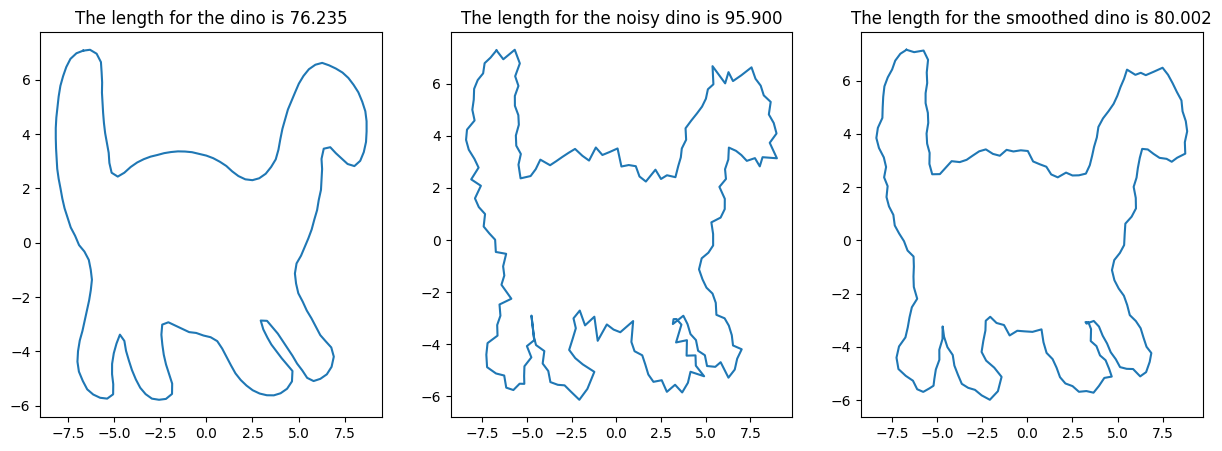

In [ ]:
hand = np.loadtxt(f"{PATH}curves/hand.txt")
dino_noisy = np.loadtxt(f"{PATH}curves/dino_noisy.txt")

# Smoothing
LAMBDA = 0.19
dino_smooth = smoothing_normal(dino_noisy, LAMBDA)

# Add the first point to the end to connect the curve
dino = np.vstack([dino, dino[0,:]])
dino_noisy = np.vstack([dino_noisy, dino_noisy[0,:]])
dino_smooth = np.vstack([dino_smooth, dino_smooth[0,:]])

# Calculate the length of the curves
dino_distance = curve_length(dino)
dino_noisy_distance = curve_length(dino_noisy)
dino_smooth_distance = curve_length(dino_smooth)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(dino[:,0], dino[:,1], label='Without noise')
ax[0].set_title(f'The length for the dino is {dino_distance:.3f}')
ax[1].plot(dino_noisy[:,0], dino_noisy[:,1], label='With noise')
ax[1].set_title(f'The length for the noisy dino is {dino_noisy_distance:.3f}')
ax[2].plot(dino_smooth[:,0], dino_smooth[:,1], label='Smoothed')
ax[2].set_title(f'The length for the smoothed dino is {dino_smooth_distance:.3f}')


